<a href="https://colab.research.google.com/github/mikeusru/neural-network-training/blob/main/3_CNNs_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Localization
We learned how to make image classifiers, but what if we need to actually find an object in a picture? At this point, we want to combine image classification with object localization. Practically, we want the x and y coordinates of an object, as well as a height and width of the bounding box surrounding it - 4 numbers in total. This doesn't require changing the model much, we just need another dense output layer with 4 units, typically on top of the global average pooling layer, and train it using MSE loss.

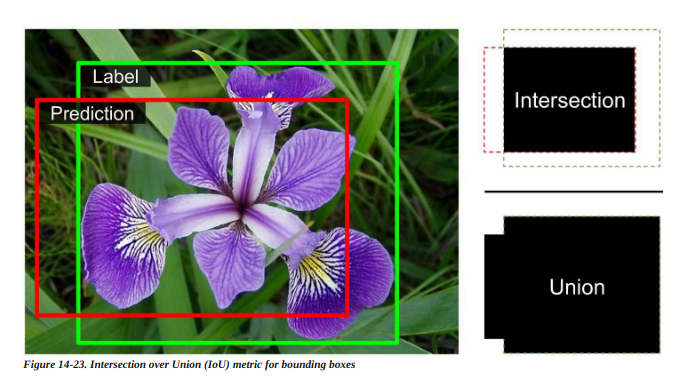

In [1]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
n_classes = len(info.features["label"].names)
test_set_raw, valid_set_raw, train_set_raw = tfds.load("tf_flowers", 
                                                        split=["train[:10%]", "train[10%:25%]", "train[25%:]"], 
                                                        as_supervised=True)

def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [2]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)

model = keras.Model(inputs=base_model.input,
                    outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"], 
              loss_weights=[0.8, 0.2],
              optimizer=optimizer,
              metrics=["accuracy"])

83689472/83683744 [==============================] - 1s 0us/step


This model could spit out bounding boxes, but our dataset doesn't have any!!! We can generate labels using a bunch of different tools depending on the task, but that's beyond the scope of this tutorial. Let's make some fake bounding boxes, just to see how our model works.

In [3]:
def add_random_bounding_boxes(images, labels):
  fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
  return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)


The training set looks like (images, (class_labels, bounding_boxes)). We feed this in and train our model.

In [4]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 36s 379ms/step - loss: 1.1639 - dense_loss: 1.3757 - dense_1_loss: 0.3170 - dense_accuracy: 0.3725 - dense_1_accuracy: 0.3047
Epoch 2/2
5/5 [==============================] - 3s 378ms/step - loss: 0.5482 - dense_loss: 0.6392 - dense_1_loss: 0.1843 - dense_accuracy: 0.7793 - dense_1_accuracy: 0.3312


To evaluate the model, we can also use IoU, or Intersection Over Union. It's the area of overlap between the predicted bounding box and target bounding box, divided by the area of their union. This is accomplished with the tf.keras.metrics.MeanIoU class, and serves as a good metric to show how well we're identifying the bounding box.


In [6]:
metrics = [tf.keras.metrics.MeanIoU(num_classes=n_classes)]